# Chatbot with Attention

Heavily based off of the implementation in https://github.com/Conchylicultor/DeepQA and https://www.tensorflow.org/tutorials/text/nmt_with_attention

## Architecture
I chose to implement a model based on this paper (https://arxiv.org/abs/1508.04025v5) that implements a seq2seq model for NMT with attention.

The final architecture borrows from both https://github.com/Conchylicultor/DeepQA and the attention model. It consists of a 2-layer LSTM based encoder and an attention + LSTM based decoder. For both the encoder and decoder, the embedding layer has dimension 32, and the hidden layers have 256 units.

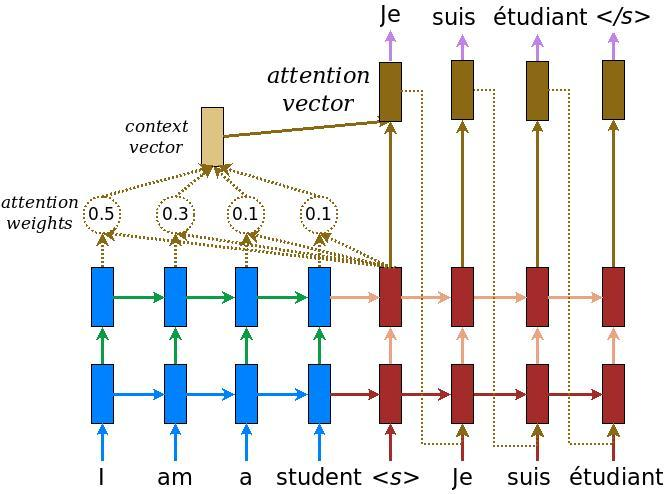

The class `LSTMAtt` below implements this model.

## Pre-trained word embeddings

Furthermore, borrowing from the DeepQA implementation, I opted to initialize the vocabulary embedding with the google News word2vec embeddings, which can be found here: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing. This made the training converge much faster and made the performance of the overall model much better.

## Dataset
The cornell movie dialogues dataset was used to train the model. I left out the OpenSubs dataset because it was more noisy and modelled dialogues less accuractely (since a question and answer could come from the same speaker). 

Another modification I made was to truncate all sentences to 5 words, this was to both speed up training, as well as lighten the modelling load, since the model doesn't have to learn longer sequences.

## Training
The Adam optimizer was used, and the model was trained with an `lr` of `0.001` for 120 epochs.

## Hyperparameters

I experimented with several settings, including the embedding dimensions, number of hidden units in the LSTMs, as well as the use of attention. I found the settings as listed above to be adequate, and quite possibly optimal (to be confirmed by doing an exhaustive search).

As for the use of attention, I have found that its use did not make a big difference to the model performance. In the final model, I chose to not use attention. This can be changed by setting `USE_ATTENTION=True` in the settings below.

## Experiments

Alot of the time, the model chooses to answer questions evasively by simply answering "I don't know". However, when giving more meaningful answers, the trained model seems to be able to identify context and provide grammatically and semantically correct answers, even though they might not always make logical sense. 

Shown below is an example of a conversation with the trained bot, several observations can be made:
- the replies are short, sometimes incomplete. this is probably due to the truncation on the training data to speed up training
- for generic questions, the bot responds quite well, giving answers that makes some sense
- for more complex questions, the bot sometimes just evades and answers "I don't know", and sometimes just gives an illogical non-response

```
Q: hi
A: hi

Q: how are you
A: fine okay pretty good

Q: what is your name
A: my name is sir launcelot

Q: tell me about yourself
A: im in an accident

Q: do you love me
A: of course

Q: what is the meaning of life
A: that you had to be

Q: how is the weather today
A: how was the fact that

Q: lets have dinner
A: well you look like good

Q: are you a bot
A: i dont know

Q: why not
A: because i dont want one
```

### Bad responses

Sometimes the bot fails to answer more complex questions in a way that makes any logical sense.

```
Q: lets have dinner
A: well you look like good

Q: how is the weather today
A: how was the fact that

Q: who is laura
A: i cant im no doctor

Q: what is cooking
A: my dream is a old

Q: can you say no
A: correct know he thinks its

Q: two plus two
A: easy wait im on my
```

I didn't bother trying to ask the bot more complex questions that may require higher-level comprehension such as entailment and / or summarization. These will be questions of the form:
```
Q: My name is David. What is my name?
Q: My name is John. What is my name?
Q: Do you prefer football or soccer?
```
Since these questions require questions longer than the length of sentences it was trained on. This will be reserved for future work.

## Further work
The quality of the bot's responses could be significantly improved with the following improvements:
- truncating sentences less
- using a larger dataset / multiple datasets (the reddit and ubuntu dialog datasets would be extremely useful for this)
- using a memory vector to carry over information across multiple question-answer exchanges

# Usage of the notebook

If run as a standalone notebook (without cloning the original repo this notebook was found in) set `STANDALONE_MODE=True`

To run the notebook, simply run all cells until the end. The `Chatbot` class implements the chatbot which uses the trained seq2seq model. Simply give your question as an argument to `Chatbot.chat()` method to get a response:
```
chatbot = Chatbot(model, qadataset)
chatbot.chat('how are you')
```

By default, the script does not train the model, but downloads a pre-trained model from github. This can be changed by setting `TRAIN_MODEL=True` in the script settings below.

By default embeddings are not made from scratch, but also downloaded from github. This can be changed by setting `MAKE_EMBEDDING_JSON=True`. The embeddings will need to be re-made, if any of the hyperparams `TEXT_MAX_LEN`, `NUM_EXAMPLES`, `EMBEDDING_DIM` or `DATASETS` are changed.

To re-make the embeddings, you will need to download  the google wprd2vec emneddings: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing, and make it available at `GOOGLE_EMB_PATH`

# Global Hyperparams

In [39]:
# script settings
STANDALONE_MODE = True
TRAIN_MODEL = False
DOWNLOAD_DATA = True
MODEL_SAVE_PATH = 'training_checkpoints/no_att_final_checkpoint'
MAKE_EMBEDDING_JSON = False
GOOGLE_EMB_PATH = "GoogleNews-vectors-negative300.bin"

In [6]:
# Training hyperparameters
BATCH_SIZE = 256
NUM_EXAMPLES = None
EMBEDDING_DIM = 32
UNITS = 256
TEXT_MAX_LEN = 5
USE_ATTENTION = False
DATASETS = ('cornell',)

In [7]:
EMBEDDING_JSON_PATH = f"embeddings/embeddings_{'_'.join(DATASETS)}_ne_{NUM_EXAMPLES}_maxlen_{TEXT_MAX_LEN}.json"

# Download Files and Setup

In [8]:
import os, shutil

In [9]:
if STANDALONE_MODE:
    if not os.path.exists('datasets.py'):
        !wget https://raw.githubusercontent.com/whong92/natural-language-processing/master/honor/datasets.py

    if not os.path.exists('download_cornell.sh'):
        !wget https://raw.githubusercontent.com/whong92/natural-language-processing/master/honor/download_cornell.sh

    if not os.path.exists('download_opensubs.sh'):
        !wget https://raw.githubusercontent.com/whong92/natural-language-processing/master/honor/download_opensubs.sh

In [10]:
if not os.path.exists(EMBEDDING_JSON_PATH) and not MAKE_EMBEDDING_JSON:
    !wget https://raw.githubusercontent.com/whong92/natural-language-processing/master/honor/embeddings/embeddings_cornell_ne_None_maxlen_5.json
    if not os.path.exists('embeddings'): os.mkdir('embeddings')
    shutil.move('embeddings_cornell_ne_None_maxlen_5.json', EMBEDDING_JSON_PATH)

In [11]:
if DOWNLOAD_DATA:
    !chmod +x ./download_cornell.sh ./download_opensubs.sh
    !./download_cornell.sh
    !./download_opensubs.sh

In [12]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io

import time

from tqdm import tqdm
import json

In [13]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Dataset prep

The `QADataset` class implements loading the data, tokenizing and generating training batches

In [14]:
from datasets import readCornellData, readOpensubsData, extractText

In [15]:
def preprocess_sentence(w):
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [16]:
def create_dataset(lines, num_examples):
    
    if num_examples is not None: 
      _lines = lines[:num_examples]
    else:
      _lines = lines
    word_pairs = [[preprocess_sentence(w) for w in l]  for l in _lines[:num_examples]]

    return zip(*word_pairs)

In [17]:
def tokenize(text, tokenizer):
    tensor = tokenizer.texts_to_sequences(text)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
    return tensor

def fit_tokenizer(ques, ans):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='', oov_token='<unk>')
    text = ques + ans
    tokenizer.fit_on_texts(text)

    tensor = tokenize(text, tokenizer)

    return tensor[:len(ques)], tensor[len(ques):], tokenizer

In [18]:
class QADataset:
    def __init__(
        self, 
        path='data',
        datasets=('cornell',), 
        text_max_len=100,
        num_examples=20,
        val_size=0.1,
        batch_size=1,
        eval_batch_size=1,
    ):
        datasets = set(datasets)
        text_raw = []
        if 'cornell' in datasets:
            text_raw.extend(readCornellData(f'{path}/cornell', max_len=text_max_len))
        if 'opensubs' in datasets:
            text_raw.extend(readOpensubsData(f'{path}/opensubs', max_len=text_max_len))
        
        self.batch_size = batch_size
        self.eval_batch_size = eval_batch_size
        
        text_q, text_a = create_dataset(text_raw, num_examples)
        ques_tensor, ans_tensor, tokenizer = fit_tokenizer(text_q, text_a)
        self.tokenizer = tokenizer
        self.ques_tensor_train, self.ques_tensor_val, self.ans_tensor_train, self.ans_tensor_val = \
            train_test_split(ques_tensor, ans_tensor, test_size=val_size)

    def vocab_size(self):
        return len(self.tokenizer.word_index) + 1

    def make_tf_dataset(self, train=True):
        if train:
            ques_tensor = self.ques_tensor_train
            ans_tensor = self.ans_tensor_train
        else:
            ques_tensor = self.ques_tensor_val
            ans_tensor = self.ans_tensor_val
        dataset = tf.data.Dataset.from_tensor_slices((ques_tensor, ans_tensor))\
            .shuffle(len(ques_tensor))
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        return dataset

    def tensor_2_text(self, tensor):
        pass
      
    def text_2_tensor(self, text):
        return tokenize(text, self.tokenizer)

    def steps_per_epoch(self, train=True):
        if train:
            return np.ceil(len(self.ques_tensor_train) / self.batch_size)
        return np.ceil(len(self.ques_tensor_val) / self.eval_batch_size)

In [19]:
qadataset = QADataset(datasets=DATASETS, batch_size=BATCH_SIZE, num_examples=NUM_EXAMPLES, text_max_len=TEXT_MAX_LEN)
qa_tf_ds = qadataset.make_tf_dataset()
example_input_batch, example_target_batch = next(iter(qa_tf_ds))
example_input_batch.shape, example_target_batch.shape

100%|██████████| 83097/83097 [00:03<00:00, 25367.30it/s]


(TensorShape([256, 7]), TensorShape([256, 7]))

In [20]:
len(qa_tf_ds)

777

# Embeddings

The `Embeddings` class is responsible for making the embedding layer from the Google New pretrained word2vec embeddings, and reducing the dimensionality of the embeddings if the target layer is smaller than the original embeddings

In [21]:
class Embeddings:
    def __init__(self, dataset, emb_json):
      
      self.dataset = dataset
      self.emb_json = emb_json
      with open(emb_json, 'r') as fp:
          self.emb_json = json.load(fp)
      
      src_embedding_dim = None
      for v in self.emb_json.values():
          src_embedding_dim = len(v)
          break
      
      self.emb_vec = np.random.uniform(-0.25,0.25,(len(qadataset.tokenizer.word_index) + 1, src_embedding_dim))
      for word, emb in self.emb_json.items():
          idx = qadataset.tokenizer.word_index[word]
          self.emb_vec[idx] = np.array(emb)

    def get_compressed_emb(self, dim):
        assert dim < self.emb_vec.shape[1]
        U, s, Vt = np.linalg.svd(self.emb_vec, full_matrices=False)
        S = np.zeros((dim, dim), dtype=float)
        S[:, :] = np.diag(s[:dim])
        return np.dot(U[:, :dim], S)
    
    @staticmethod
    def make_from_google_embeddings(google_emb_path, output_path):
        embeddings_format = os.path.splitext(google_emb_path)[1][1:]
        print("Loading pre-trained word embeddings from %s " % google_emb_path)
        embeddings = {}
        with open(google_emb_path, "rb") as f:
            header = f.readline()
            vocab_size, vector_size = map(int, header.split())
            binary_len = np.dtype('float32').itemsize * vector_size
            for line in tqdm(range(vocab_size)):
                word = []
                while True:
                    ch = f.read(1)
                    if ch == b' ':
                        word = b''.join(word).decode('utf-8')
                        break
                    if ch != b'\n':
                        word.append(ch)
                if word in qadataset.tokenizer.word_index:
                    if embeddings_format == 'bin':
                        vector = np.fromstring(f.read(binary_len), dtype='float32')
                    elif embeddings_format == 'vec':
                        vector = np.fromstring(f.readline(), sep=' ', dtype='float32')
                    else:
                        raise Exception("Unkown format for embeddings: %s " % embeddings_format)
                    embeddings[word] = vector.tolist()

                else:
                    if embeddings_format == 'bin':
                        f.read(binary_len)
                    elif embeddings_format == 'vec':
                        f.readline()
                    else:
                        raise Exception("Unkown format for embeddings: %s " % embeddings_format)
        with open(output_path, "w") as fp:
            json.dump(embeddings, fp)

In [22]:
if MAKE_EMBEDDING_JSON:
    Embeddings.make_from_google_embeddings(GOOGLE_EMB_PATH, EMBEDDING_JSON_PATH)

In [23]:
print(EMBEDDING_JSON_PATH)
emb = Embeddings(qadataset, EMBEDDING_JSON_PATH)

embeddings/embeddings_cornell_ne_None_maxlen_5.json


# The model - LSTM with Attention

`Encoder` implements the encoder, `Decoder` implements the decoder with attention, and `LSTMAtt` implements the whole model.

In [24]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, embedding=None):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstms = [
        tf.keras.layers.LSTM(
            self.enc_units, 
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.LSTM(
            self.enc_units, 
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'),
    ]
    # initialize with pre-trained embeddings
    if embedding is not None:
        print("Encoder: initializing pre-trained embeddings")
        self.embedding(tf.convert_to_tensor([[0]])) # dummy forward to initialize weights
        enc_emb_vec = embedding.get_compressed_emb(dim=embedding_dim)
        self.embedding.set_weights([enc_emb_vec])

  def call(self, x, hidden):
    x = self.embedding(x)
    states = []
    for lstm in self.lstms:
      x, h, c = lstm(x, initial_state=[hidden, hidden])
      states.extend([h, c])
    return x, states

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [25]:
encoder = Encoder(qadataset.vocab_size(), EMBEDDING_DIM, UNITS, BATCH_SIZE, emb)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
for h in sample_hidden:
  print ('Encoder Hidden state shape: (batch size, units) {}'.format(h.shape))

Encoder: initializing pre-trained embeddings
Encoder output shape: (batch size, sequence length, units) (256, 7, 256)
Encoder Hidden state shape: (batch size, units) (256, 256)
Encoder Hidden state shape: (batch size, units) (256, 256)
Encoder Hidden state shape: (batch size, units) (256, 256)
Encoder Hidden state shape: (batch size, units) (256, 256)


In [26]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [27]:
sample_hidden_flat = tf.concat(sample_hidden, axis=1)

In [28]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden_flat, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (256, 256)
Attention weights shape: (batch_size, sequence_length, 1) (256, 7, 1)


In [29]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, embedding=None, attention=False):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstms = [
            tf.keras.layers.LSTM(
                self.dec_units, 
                return_sequences=True,
                return_state=True,
                recurrent_initializer='glorot_uniform'),
            tf.keras.layers.LSTM(
                self.dec_units, 
                return_sequences=True,
                return_state=True,
                recurrent_initializer='glorot_uniform'),
        ]
        self.fc = tf.keras.layers.Dense(vocab_size)
        # initialize with pre-trained embeddings
        if embedding is not None:
            print("Decoder: initializing pre-trained embeddings")
            # dummy forward to initialize weights
            self.embedding(tf.convert_to_tensor([[0]]))
            self.fc(np.zeros((1, dec_units,)))
            emb_vec = embedding.get_compressed_emb(dim=embedding_dim)
            self.embedding.set_weights([emb_vec])
            out_vec = embedding.get_compressed_emb(dim=dec_units)
            self.fc.set_weights([out_vec.transpose(), np.zeros((out_vec.shape[0],))])

        self.attention = None
        # used for attention
        if attention: self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        if self.attention is not None: 
            # enc_output shape == (batch_size, max_length, hidden_size)
            hidden_flat = tf.concat(hidden, axis=1)
            context_vector, attention_weights = self.attention(hidden_flat, enc_output)
            # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
            x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the LSTM
        states = []
        for i, lstm in enumerate(self.lstms):
            x, h, c = lstm(x, initial_state=hidden[2*i:2*(i+1)])
            states.extend([h, c])
        output = x
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, states, None #attention_weights

In [30]:
decoder = Decoder(qadataset.vocab_size(), EMBEDDING_DIM, UNITS, BATCH_SIZE, emb, attention=USE_ATTENTION)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder: initializing pre-trained embeddings
Decoder output shape: (batch_size, vocab size) (256, 37192)


In [31]:
def matrix_to_text(tokr, preds):
    text_outputs = []
    end_tok = tokr.word_index['<end>']
    for pred in preds.numpy():
        end_idxs = np.sort(np.argwhere(pred==end_tok)[:, 0])
        if len(end_idxs) > 0: end_idx = end_idxs[0]
        else: end_idx = len(pred)
        text_outputs.append(tokr.sequences_to_texts([pred[:end_idx].tolist()]))
    return text_outputs

In [32]:
class LSTMAtt(tf.keras.Model):
    def __init__(self, qadataset, embedding_dim, units, batch_size, max_output_len, embedding=None, attention=True):
        super(LSTMAtt, self).__init__()
        self.enc = Encoder(qadataset.vocab_size(), embedding_dim, units, batch_size, embedding=embedding)
        self.dec = Decoder(qadataset.vocab_size(), embedding_dim, units, batch_size, embedding=embedding, attention=attention)
        self.enc_hidden = self.enc.initialize_hidden_state()
        self.qadataset = qadataset
        self.max_output_len = max_output_len
    
    def encode(self, inp):
        return self.enc(inp, self.enc_hidden)

    def force_decode(self, target, enc_hidden, enc_output):
        # Teacher forcing - feeding the target as the next input
        
        preds = []
        dec_input = tf.expand_dims(target[:, 0], 1)
        dec_hidden = enc_hidden
        for t in range(1, target.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = self.dec(dec_input, dec_hidden, enc_output)

            preds.append(tf.expand_dims(predictions, axis=1))

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, t], 1)
        return tf.concat(preds, axis=1)
    
    def decode(self, enc_hidden, enc_output, output_text=False, output_att=False, output_conf=False):
        # greedy decoding
        tokr = self.qadataset.tokenizer
        dec_input = tf.cast(tf.expand_dims(
            [tokr.word_index['<start>']] * enc_hidden[0].shape[0], 1
        ), tf.int64)
        is_end = tf.zeros((enc_hidden[0].shape[0], ), dtype=tf.dtypes.bool)
        end_tok = tokr.word_index['<end>']
        dec_hidden = enc_hidden
        preds = []
        logits = []
        for t in range(self.max_output_len):
            predictions, dec_hidden, attention_weights = \
                self.dec(dec_input, dec_hidden, enc_output)

            # storing the attention weights to plot later on
            # attention_weights = tf.reshape(attention_weights, (-1, ))
            # attention_plot[t] = attention_weights.numpy()
            logits.append(tf.expand_dims(predictions, axis=1))
            predicted_ids = tf.argmax(predictions, axis=1, )
            predicted_confs = tf.reduce_max(predictions, axis=1, )
            is_end = tf.math.logical_or(is_end, predicted_ids==end_tok)
            if tf.math.reduce_all(is_end): 
                break
                
            # the predicted ID is fed back into the model
            dec_input = tf.expand_dims(predicted_ids, axis=1)
            preds.append(dec_input)

        if len(preds) > 0:
            preds = tf.concat(preds, axis=1)
            logits = tf.concat(logits, axis=1)
        else:
            preds = tf.convert_to_tensor([[]]*enc_hidden.shape[0])
            logits = tf.convert_to_tensor([[[]]*enc_hidden.shape[1]]*enc_hidden.shape[0])
        ret = [preds, logits]
        if output_text:
            ret.append(matrix_to_text(tokr, preds))
        return ret

    @property
    def trainable_variables(self):
        return self.enc.trainable_variables + self.dec.trainable_variables

In [33]:
model = LSTMAtt(qadataset, EMBEDDING_DIM, UNITS, BATCH_SIZE, max_output_len=TEXT_MAX_LEN, embedding=emb, attention=USE_ATTENTION)

Encoder: initializing pre-trained embeddings
Decoder: initializing pre-trained embeddings


In [34]:
enc_output, enc_hidden = model.encode(example_input_batch)
print(enc_output.shape)
for h in enc_hidden:
    print(h.shape)
preds, logits, text = model.decode(enc_hidden, enc_output, output_text=True)
print(text[:10])

(256, 7, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
[['indivisible indivisible unclench doorbell masturbate'], ['visas indivisible stateroom stateroom quo'], ['blinkers indivisible indivisible unclench doorbell'], ['recidivism recidivism warmest pistachios nicotine'], ['recidivism recidivism spam spam spam'], ['indivisible indivisible unclench staircase penitent'], ['deadliest stateroom stateroom stateroom rabbinic'], ['equitation equitation absentia letters mayday'], ['recidivism recidivism unready parmesan hypothalamus'], ['recidivism recidivism password lymph spam']]


# Training

In [35]:
from nltk.translate import bleu_score

In [36]:
def loss_function(real, pred, loss_object):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [37]:
class Trainer:
    def __init__(self, model, dataset, epochs, lr=0.01):
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')
        self.model = model
        self.dataset = dataset
        self.epochs = epochs
        self.lr = lr
    
    def train(self, start_epoch=0):
        
        perps = []
        for epoch in range(start_epoch, start_epoch+self.epochs):
            start = time.time()

            total_loss = 0
            ds = self.dataset.make_tf_dataset()
            steps_per_epoch = self.dataset.steps_per_epoch()

            pbar = tqdm(enumerate(ds.take(steps_per_epoch)), total=steps_per_epoch)
            for (batch, (inp, targ)) in pbar:
                with tf.GradientTape() as tape:
                    enc_output, enc_hidden = model.encode(inp)
                    preds = model.force_decode(targ, enc_hidden, enc_output)
                    loss = loss_function(targ[:,1:], preds, self.loss_object)
                    pbar.set_description(f"loss = {loss:.4f}")
                variables = model.trainable_variables
                gradients = tape.gradient(loss, variables)
                self.optimizer.apply_gradients(zip(gradients, variables))
                total_loss += loss
            perp = self.evaluate(calc_bleu=False, calc_perp=True, force_decode=False, preview=True)[0]
            perps.append(perp)

            save_path = f'{MODEL_SAVE_PATH}/model_epoch_{epoch}'
            print(f"saving weights to {save_path}")
            model.save_weights(save_path)

            print(
                f'Epoch {epoch + 1} Loss {total_loss / steps_per_epoch:.4f} Perplexity {perp:.4f}'
            )
            print(f'Time taken for 1 epoch {time.time() - start} sec\n')
            return perps
    
    def evaluate(self, calc_bleu=True, calc_perp=False, preview=True, force_decode=False):
        ds = self.dataset.make_tf_dataset(train=False)
        steps_per_epoch = self.dataset.steps_per_epoch(train=False)
        
        all_preds = []
        all_targets = []
        perp = 0.
        
        for (batch, (inp, targ)) in enumerate(ds.take(steps_per_epoch)):
            enc_output, enc_hidden = model.encode(inp)
            if force_decode:
                logits = model.force_decode(targ, enc_hidden, enc_output)
                texts = []
            else:
                preds, logits, texts = model.decode(enc_hidden, enc_output, output_text=True)
            if calc_perp:
                min_len = min(targ.shape[1]-1, logits.shape[1]) # sometimes decoded output may be different lengths
                loss = loss_function(targ[:,1:min_len+1], logits[:,:min_len,:], self.loss_object)
                perp += 2**loss
            if preview:
                target_text = matrix_to_text(self.dataset.tokenizer, targ[:,1:])
                all_preds.extend([text for text in texts])
                all_targets.extend(target_text)
                
        if preview:
            print(all_preds[:10], all_targets[:10])
        ret = []
        if calc_bleu:
            ret.append(bleu_score.corpus_bleu(all_targets, all_preds))
        if calc_perp:
            ret.append(perp/steps_per_epoch)
        return ret

In [38]:
perps = []
if TRAIN_MODEL:
    # train for 80 epochs at lr = 0.002
    EPOCHS = 80
    trainer = Trainer(model, qadataset, EPOCHS, lr=0.002)
    perps.extend(trainer.train(0))
    # 40 epochs at lr = 0.001
    EPOCHS = 40
    trainer = Trainer(model, qadataset, EPOCHS, lr=0.001)
    perps.extend(trainer.train(80))
else:
    epoch = 138
    # download model from github
    if not os.path.exists(f'{MODEL_SAVE_PATH}/model_epoch_{epoch}'):
        !wget https://raw.githubusercontent.com/whong92/natural-language-processing/master/honor/training_checkpoints/no_att_final_checkpoint/model_epoch_{epoch}.data-00000-of-00001  -P $MODEL_SAVE_PATH
        !wget https://raw.githubusercontent.com/whong92/natural-language-processing/master/honor/training_checkpoints/no_att_final_checkpoint/model_epoch_{epoch}.index  -P $MODEL_SAVE_PATH
    model.load_weights(f"{MODEL_SAVE_PATH}/model_epoch_{epoch}")

--2021-03-24 23:38:12--  https://raw.githubusercontent.com/whong92/natural-language-processing/master/honor/training_checkpoints/no_att_final_checkpoint/model_epoch_138.data-00000-of-00001
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54326716 (52M) [application/octet-stream]
Saving to: ‘training_checkpoints/no_att/model_epoch_138.data-00000-of-00001’

model_epoch_138.dat 100%[===================>]  51.81M  6.87MB/s    in 6.8s    

2021-03-24 23:38:19 (7.62 MB/s) - ‘training_checkpoints/no_att/model_epoch_138.data-00000-of-00001’ saved [54326716/54326716]

--2021-03-24 23:38:19--  https://raw.githubusercontent.com/whong92/natural-language-processing/master/honor/training_checkpoints/no_att_final_checkpoint/model_epoch_138.index
Resolving raw.githubusercont

It is quite interesting to note that although the validation perplexity is going up, the general subjective 'quality' of the conversation model gets better and better. This may be due to two things: 
- Perhaps subjective performance may involve memorizing more style from the training set, than making acccurate conversation
- The test conversations lack any context, making predicting the exact response difficult.

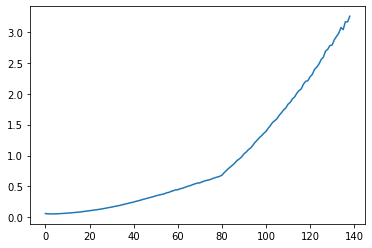

In [155]:
plt.plot(perps)

# Chatbot

The `Chatbot` class accepts the `LSTMAtt` model and a `QADataset` object as arguments.

In [45]:
class Chatbot:
    
    def __init__(self, model, dataset):
        self.model = model
        self.dataset = dataset
    
    def chat(self, question: str):
        question_words = preprocess_sentence(extractText(question)).split()
        input_text_tensor = qadataset.text_2_tensor([question_words]*BATCH_SIZE)
        pad_len = max(2 + TEXT_MAX_LEN, input_text_tensor.shape[1])
        input_text_tensor_padded = np.zeros(shape=(BATCH_SIZE, pad_len))
        input_text_tensor_padded[:,:input_text_tensor.shape[1]] = input_text_tensor
        enc_output, enc_hidden = model.encode(input_text_tensor_padded)
        _, _, text = model.decode(enc_hidden, enc_output, output_text=True)
        return ''.join(text[0])

In [46]:
chatbot = Chatbot(model, qadataset)

In [47]:
questions = [
    "hi",
    "how are you",
    "what is your name",
    "tell me about yourself",
    "do you love me",
    "what is the meaning of life",
    "how is the weather today",
    "lets have dinner",
    "are you a bot",
    "why not",
    "who is laura",
    "what is cooking",
    "can you say no",
    "two plus two"
]

In [48]:
answers = []
for question in questions:
    answers.append(chatbot.chat(question))

In [49]:
for question, answer in zip(questions, answers):
    print(f'Q: {question}')
    print(f'A: {answer}')
    print()

Q: hi
A: hi

Q: how are you
A: fine okay pretty good ive

Q: what is your name
A: my name is sir launcelot

Q: tell me about yourself
A: im in an accident

Q: do you love me
A: of course

Q: what is the meaning of life
A: that you had to be

Q: how is the weather today
A: how was the fact that

Q: lets have dinner
A: well you look like good

Q: are you a bot
A: i dont know

Q: why not
A: because i dont want one

Q: who is laura
A: i cant im no doctor

Q: what is cooking
A: my dream is a old

Q: can you say no
A: correct know he thinks its

Q: two plus two
A: easy wait im on my

